# Compute Cl on galaxy overdensities

- author : Sylvie Dagoret-Campagne
- affliliation : IJCLab/in2p3/CNRS
- creation date : July 28th 2020


In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import pyarrow

In [3]:
pyarrow.__version__

'0.15.1'

In [4]:
from pyspark.sql.functions import col, pandas_udf 
from pyspark.sql.types import LongType

from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

In [5]:
# here is how we create a function ('Ang2Pix') that can be called by dataframes
# it takes as input the "ra" and "dec" values (which are not very different from theta/phi)
# and returns the pixel number (but as pandas series for efficiency)
import numpy as np
import pandas as pd
import healpy as hp

nside=512

In [6]:
def Ang2Pix_func(ra: pd.Series, dec: pd.Series) -> pd.Series:
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

In [7]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
#gal = gal.withColumn("ihealpix",pd_ang2pix(gal["RA"],gal["DEC"]))

## Get parquet files


### scan all availables files

In [8]:
import os,re

In [9]:
the_input_dir="/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/dpdd/Run2.2i-dr6b/dc2_object_run2.2i_dr6b"

In [10]:
the_list_of_files=os.listdir(the_input_dir)

### sort all files

In [11]:
the_sorted_list_of_files=sorted(the_list_of_files)

### filter the good parquet files

In [12]:
selected_files=[]
for filename in the_sorted_list_of_files:
    sel_filename=re.findall("^dc2_object_run2.2i_dr6b_tract[0-9][0-9][0-9][0-9].parquet$",filename)
    if len(sel_filename) > 0:
        selected_files.append(sel_filename[0])

In [13]:
InputPath = [the_input_dir + "/{}".format(filename) for filename in selected_files]

### Read files with spark

In [14]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()

# Read the data as DataFrame
#df = spark.read.format("parquet").load(datafile)

In [15]:
#InputPath = [base_dir + "/dc2_object_run2.2i_dr6b_tract2897.parquet",
#             base_dir + "/dc2_object_run2.2i_dr6b_tract2898.parquet"]

df = spark.read.parquet(*InputPath)

In [16]:
df = df.repartition(df.rdd.getNumPartitions())

### DC2 Object catalog Schema

In [17]:
# Check what we have in the file
df.printSchema()

root
 |-- snr_r_cModel: double (nullable = true)
 |-- blendedness: double (nullable = true)
 |-- psf_fwhm_u: double (nullable = true)
 |-- magerr_u_cModel: double (nullable = true)
 |-- magerr_g_cModel: double (nullable = true)
 |-- magerr_r: double (nullable = true)
 |-- magerr_i: double (nullable = true)
 |-- cModelFlux_r: double (nullable = true)
 |-- magerr_u: double (nullable = true)
 |-- tract: long (nullable = true)
 |-- Ixy_r: double (nullable = true)
 |-- I_flag_i: boolean (nullable = true)
 |-- I_flag_u: boolean (nullable = true)
 |-- IxyPSF_i: double (nullable = true)
 |-- I_flag: boolean (nullable = true)
 |-- magerr_g: double (nullable = true)
 |-- cModelFlux_flag_r: boolean (nullable = true)
 |-- psFluxErr_r: double (nullable = true)
 |-- psFlux_flag_u: boolean (nullable = true)
 |-- psf_fwhm_y: double (nullable = true)
 |-- Ixx_g: double (nullable = true)
 |-- cModelFluxErr_g: double (nullable = true)
 |-- good: boolean (nullable = true)
 |-- IxxPSF: double (nullable = t

In [18]:
df_gal=df.filter('extendedness == true')

In [19]:
# Show all available tracts
df_gal.select('tract').distinct().show()

+-----+
|tract|
+-----+
| 2906|
| 3452|
| 3081|
| 3640|
| 2900|
| 2724|
| 3076|
| 3636|
| 2723|
| 3258|
| 2908|
| 4860|
| 5065|
| 5070|
| 3262|
| 3444|
| 5067|
| 2903|
| 3080|
| 3267|
+-----+
only showing top 20 rows



In [20]:
df_stat=df_gal.groupBy("tract").count()

In [21]:
df_stat.show()

+-----+------+
|tract| count|
+-----+------+
| 2906|761182|
| 3452|785896|
| 3081|828969|
| 3640|803361|
| 2900|814598|
| 2724|   177|
| 3076|819004|
| 3636|869495|
| 2723|    67|
| 3258|759685|
| 2908|652452|
| 4860| 28823|
| 5065|241883|
| 5070|640906|
| 3262|819267|
| 3444|831455|
| 5067|611197|
| 2903|794176|
| 3080|823202|
| 3267|775054|
+-----+------+
only showing top 20 rows



In [22]:
dp_stat=df_stat.toPandas()
dp_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   tract   99 non-null     int64
 1   count   99 non-null     int64
dtypes: int64(2)
memory usage: 1.7 KB


In [23]:
indexes=np.arange(len(dp_stat))

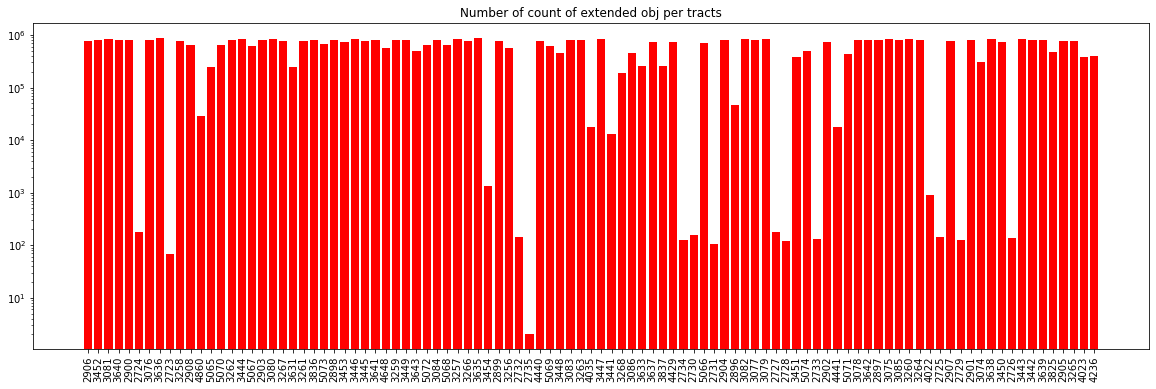

In [24]:
width=0.8
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.bar(indexes,dp_stat["count"].values,width,color='red')
ax.set_xticks(indexes)
ax.set_title("Number of count of extended obj per tracts")
xtickNames = ax.set_xticklabels(dp_stat["tract"].values)
plt.setp(xtickNames, rotation=90, fontsize=10)
plt.yscale('log')

The DM stack includes functionality to get the tract and patch number corresponding to a certain position `(RA,DEC)`. However, it is out of the scope of this tutorial.

Apache Spark provides `filter` mechanisms, which you can use to speed up data access if you only need a certain chunks of the dataset.
For the object catalog, the chunks are broken into `tract` and `patch`, and hence those are the `filters` you can use:

======= tract 2906 ================


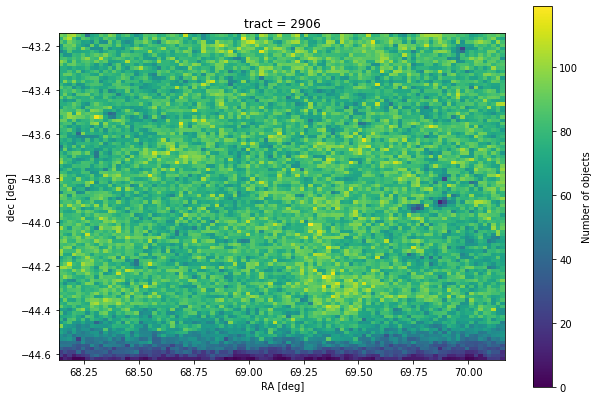

======= tract 3452 ================


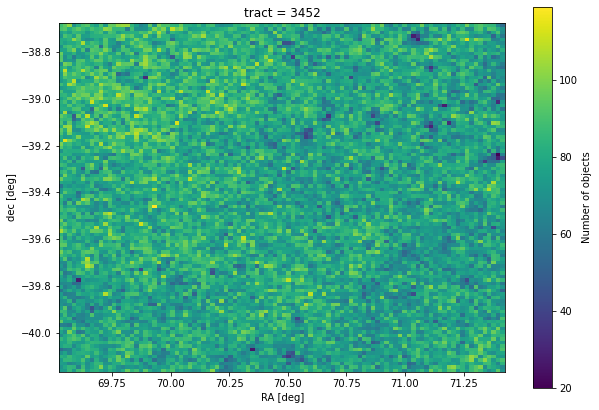

======= tract 3081 ================


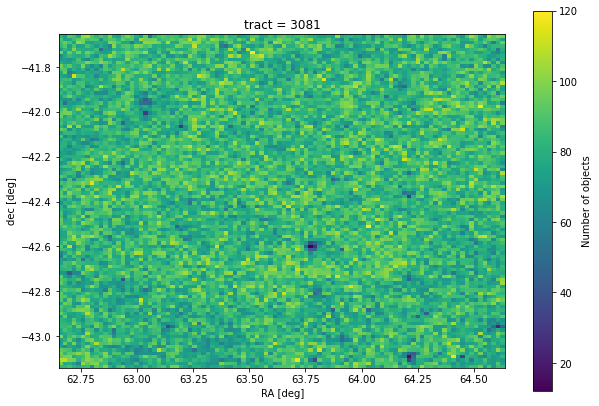

======= tract 3640 ================


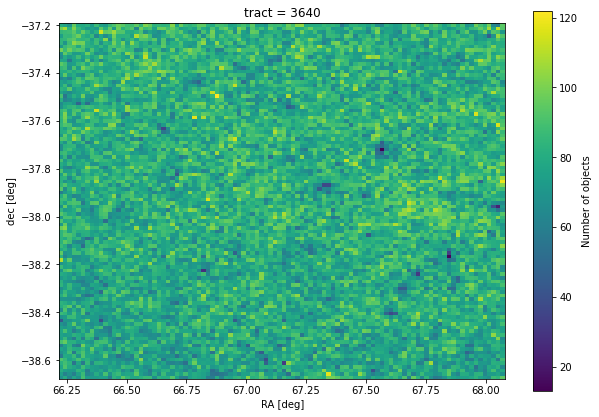

======= tract 2900 ================


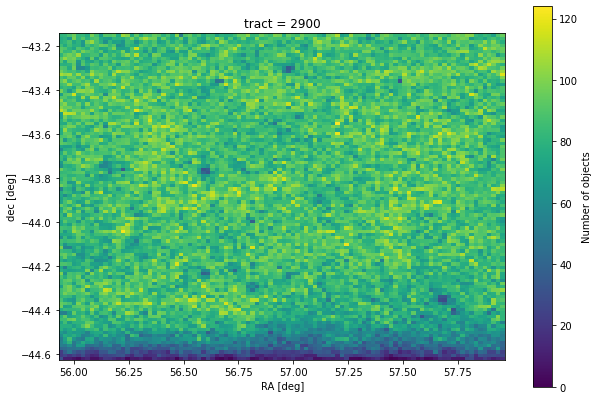

======= tract 2724 ================
======= tract 3076 ================


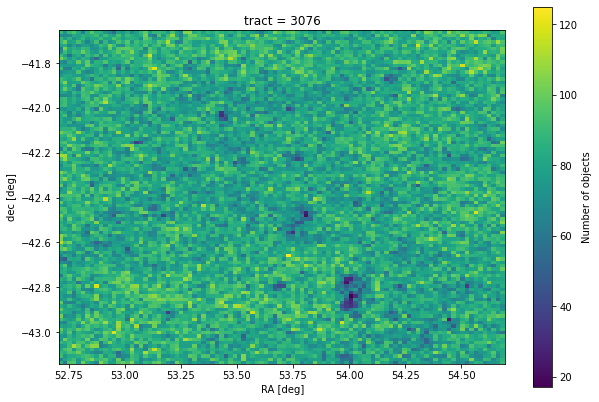

======= tract 3636 ================


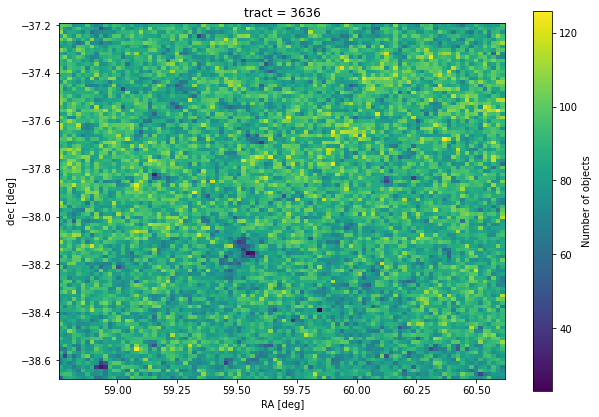

======= tract 2723 ================
======= tract 3258 ================


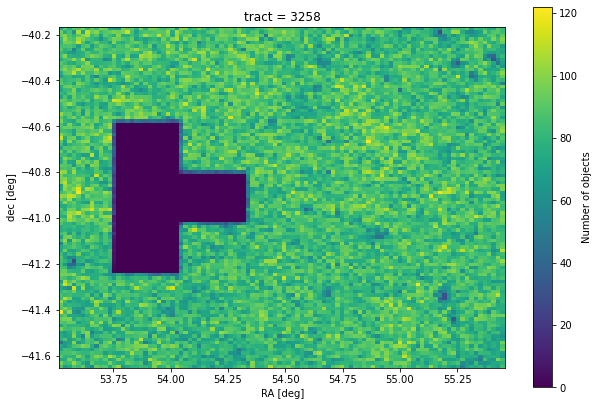

======= tract 2908 ================


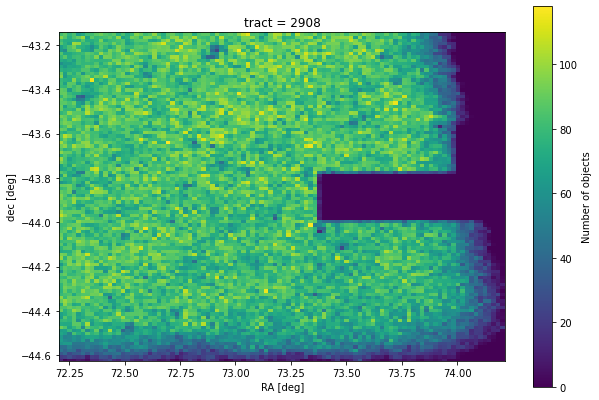

======= tract 4860 ================


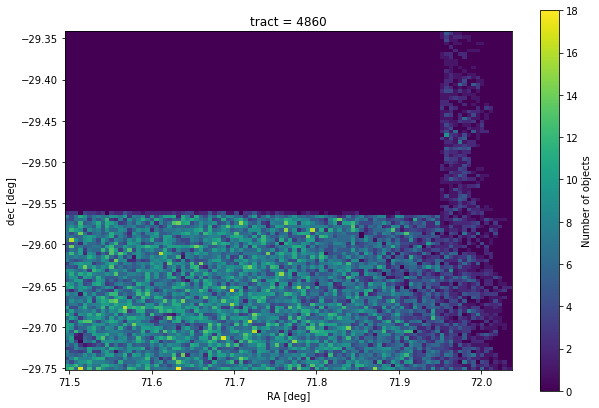

======= tract 5065 ================


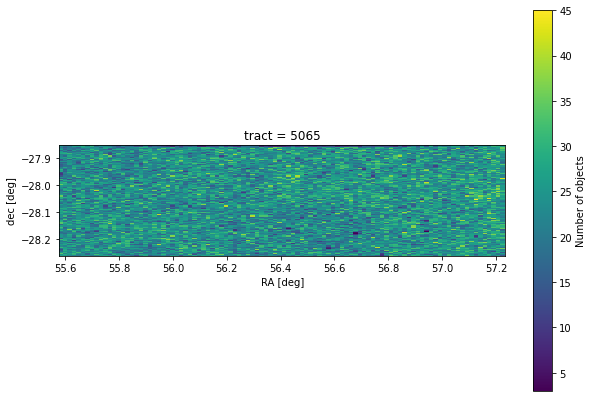

======= tract 5070 ================


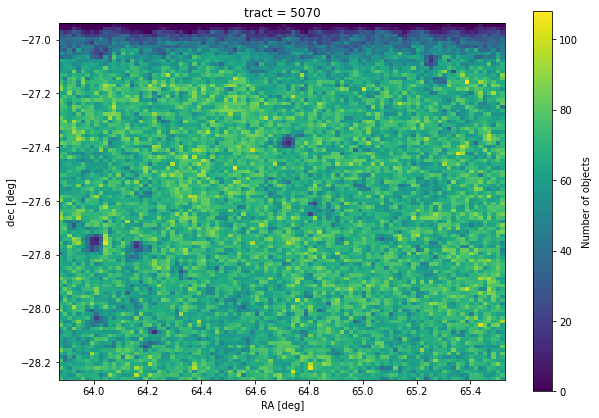

======= tract 3262 ================


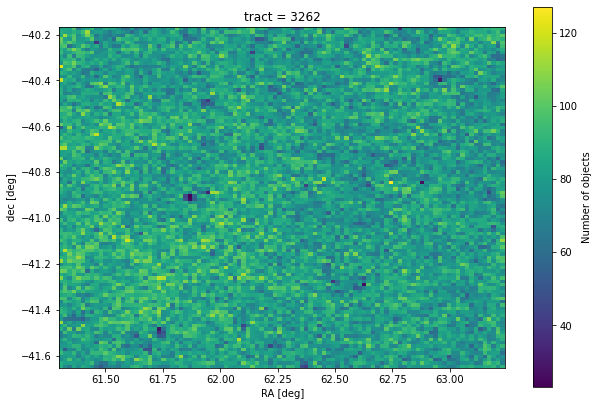

======= tract 3444 ================


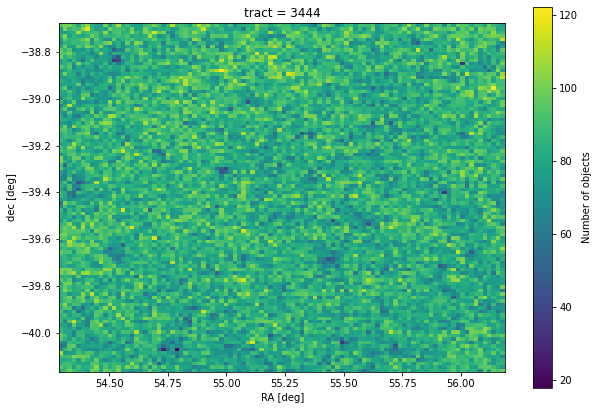

======= tract 5067 ================


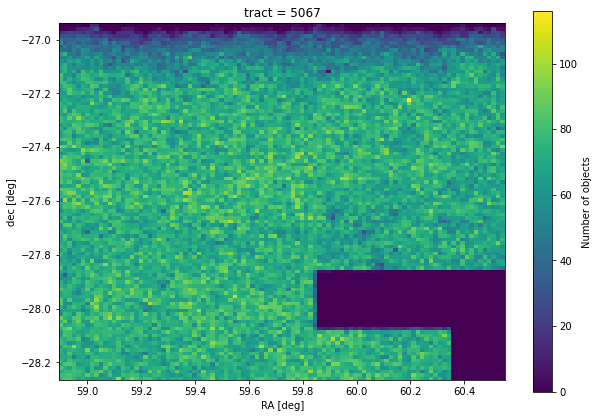

======= tract 2903 ================


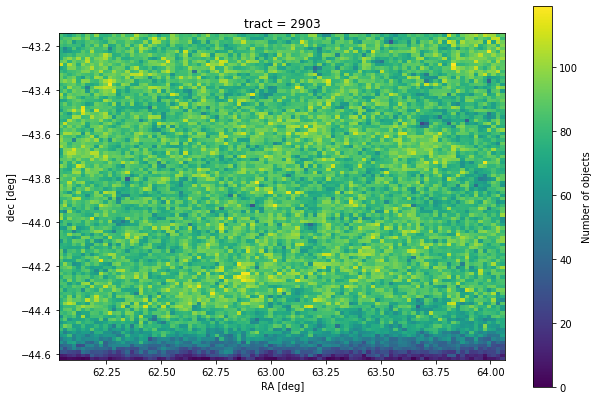

======= tract 3080 ================


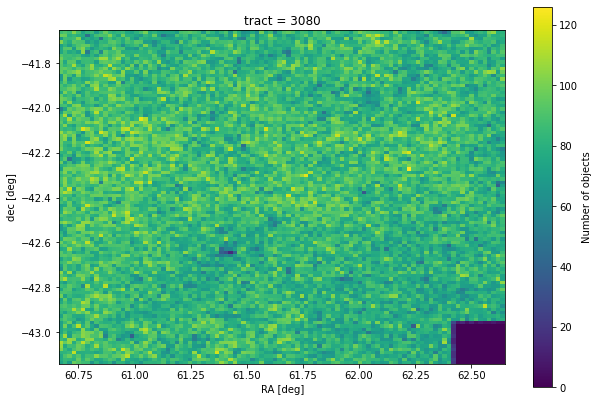

======= tract 3267 ================


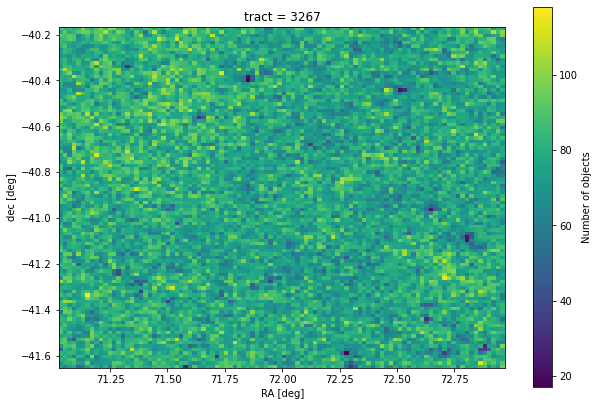

======= tract 3631 ================


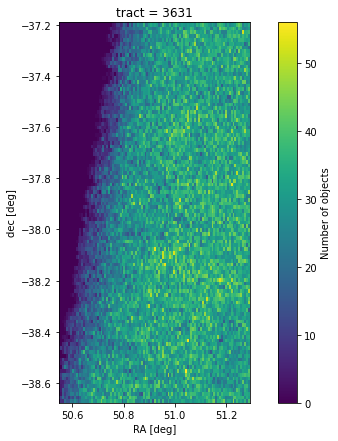

In [25]:
idx=0
for the_tract in dp_stat["tract"].values:
    selection_name = "tract == {}".format(the_tract)

    # Retrieve the ra,dec coordinates of all sources within tract number 4430
    data = df_gal.select('ra', 'dec').where(selection_name).collect()
    #data = df.select('ra', 'dec').collect()
    
    print("======= tract {} ================".format(the_tract))
    #data.describe().show()

    if dp_stat["count"].values[idx]>1e4:
    
        # `collect` returns list of list[ra, dec], so for 
        # plotting purpose we tranpose the output:
        ra, dec = np.transpose(data)

        # Plot a 2d histogram of sources
        plt.figure(figsize=(10,7))
        plt.hist2d(ra, dec, 100)
        plt.gca().set_aspect('equal')
        plt.colorbar(label='Number of objects')
        plt.xlabel('RA [deg]')
        plt.ylabel('dec [deg]');
        plt.title("tract = {}".format(the_tract))
        plt.show()
        
    idx+=1
    if idx>20:
        break

In [26]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
df_gal_healpix = df_gal.withColumn("ihealpix",pd_ang2pix(df_gal["ra"],df_gal["dec"]))

In [27]:
df_gal_healpix.printSchema()

root
 |-- snr_r_cModel: double (nullable = true)
 |-- blendedness: double (nullable = true)
 |-- psf_fwhm_u: double (nullable = true)
 |-- magerr_u_cModel: double (nullable = true)
 |-- magerr_g_cModel: double (nullable = true)
 |-- magerr_r: double (nullable = true)
 |-- magerr_i: double (nullable = true)
 |-- cModelFlux_r: double (nullable = true)
 |-- magerr_u: double (nullable = true)
 |-- tract: long (nullable = true)
 |-- Ixy_r: double (nullable = true)
 |-- I_flag_i: boolean (nullable = true)
 |-- I_flag_u: boolean (nullable = true)
 |-- IxyPSF_i: double (nullable = true)
 |-- I_flag: boolean (nullable = true)
 |-- magerr_g: double (nullable = true)
 |-- cModelFlux_flag_r: boolean (nullable = true)
 |-- psFluxErr_r: double (nullable = true)
 |-- psFlux_flag_u: boolean (nullable = true)
 |-- psf_fwhm_y: double (nullable = true)
 |-- Ixx_g: double (nullable = true)
 |-- cModelFluxErr_g: double (nullable = true)
 |-- good: boolean (nullable = true)
 |-- IxxPSF: double (nullable = t

In [29]:
m=df_gal_healpix.select('ra','dec','ihealpix').groupBy('ihealpix').count()
m.show(5)

+--------+-----+
|ihealpix|count|
+--------+-----+
| 2656944| 5236|
| 2656941| 4021|
| 2664828| 4223|
| 2653021| 5200|
| 2649047| 5401|
+--------+-----+
only showing top 5 rows



In [30]:
# get to python world (to Pandas) : 
# note that here is the action (lazy evaluation so far)
p=m.toPandas()
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12402 entries, 0 to 12401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ihealpix  12402 non-null  int32
 1   count     12402 non-null  int64
dtypes: int32(1), int64(1)
memory usage: 145.5 KB


In [31]:
p

,ihealpix,count
0,2656944,5236
1,2656941,4021
2,2664828,4223
3,2653021,5200
4,2649047,5401
...,...,...
12397,2299254,4715
12398,2315668,4699
12399,2616604,237
12400,2520479,477


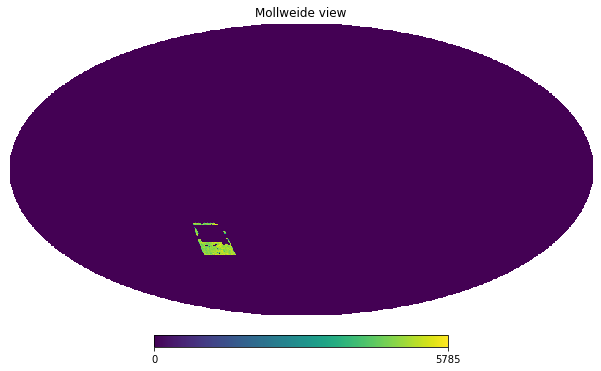

In [35]:
# the following doesn't has anything to do with spark (only Healpix)
hpMap = np.zeros(hp.nside2npix(nside))
#fill the map from the pandas object
hpMap[p['ihealpix'].values]=p['count'].values
#plot using standard healpy function
hp.mollview(hpMap)